In [48]:
import pandas as pd
import numpy as np
import seaborn as sns
%matplotlib inline
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, confusion_matrix, precision_score, accuracy_score


In [197]:
targetPeriod="2018 - 01"
CurrentYear = 2018

# create a list of all periods
allPeriods = []
for i in range (1,14):
     allPeriods.append(str(CurrentYear)+ ' - ' +  str("%02d" % (i,)))

futurePeriods = [i for i in allPeriods if i >= targetPeriod]


In [198]:
data = pd.read_excel('../data.xlsx')
data = data[[
       'Total Estimated Revenue', 
       'Current Status', 'Sales Stage',
        'Service Line Group', 'Service Line', "Close Period",
       'Industry', 
       'Market']]
data = data[data['Service Line Group'] == "Technology"]
data['Current Status'].fillna("nothing", inplace=True)
data['OSL']=data['Current Status'].str.contains('OSL')
data['OSL'].replace([False,True],[0,1],inplace=True)
data.drop("Current Status", axis=1, inplace=True)
data.drop("Service Line Group", axis=1, inplace=True)

In [199]:
sl = pd.get_dummies(data["Service Line"], drop_first=True)
ind = pd.get_dummies(data["Industry"], drop_first=True)
mark = pd.get_dummies(data["Market"], drop_first=True)
data.drop("Service Line", axis=1, inplace=True)
data.drop("Industry", axis=1, inplace=True)
data.drop("Market", axis=1, inplace=True)
data = pd.concat([data, sl, ind, mark],axis=1)


In [200]:

closeDeals = data[data['Sales Stage'].str.contains("Closed")].copy()
closeDeals.drop("Close Period", axis=1, inplace = True)
closeDeals['Sales Stage'].replace(["06 - Closed - Sold/Fermer - Vendu","07 - Closed - Lost/Fermer - Perdu", "08 - Closed - Abandoned/Fermer - Abandonné"],[1,0,0],inplace=True)



In [201]:
x= closeDeals.drop('Sales Stage', axis=1)
y= closeDeals['Sales Stage']

In [202]:
scaler = StandardScaler()
scaler.fit(x)
x = scaler.transform(x)

In [203]:
x_train, x_test, y_train, y_test = train_test_split(x,y,test_size=0.33)

In [204]:
lg = LogisticRegression()
lg.fit(x_train, y_train)
pred=lg.predict(x_test)


In [205]:
rf = RandomForestClassifier()
rf.fit(x_train, y_train)
pred = rf.predict(x_test)

In [206]:

print(classification_report(y_test, pred))
print(confusion_matrix(y_test, pred))

             precision    recall  f1-score   support

          0       0.73      0.79      0.76       170
          1       0.61      0.51      0.56       105

avg / total       0.68      0.69      0.68       275

[[135  35]
 [ 51  54]]


In [176]:
preddata = data[data['Close Period']==targetPeriod].copy()
preddata= preddata[~preddata['Sales Stage'].str.contains('Closed')]
preddata = preddata.drop('Sales Stage', axis=1)
preddata = preddata.drop("Close Period", axis=1)

In [177]:
scaler = StandardScaler()
scaler.fit(preddata)
predscaled = scaler.transform(preddata)

In [178]:
newpred = rf.predict(predscaled)
newpred_prob = rf.predict_proba(predscaled )

In [179]:
np.multiply([row[1] for row in newpred_prob] , preddata['Total Estimated Revenue']).sum()
# preddata[newpred==1]

83533773.50000001

In [180]:
def runRf(x,y,predx):
    x_train = x
    y_train = y
    rf = RandomForestClassifier()
#     rf = LogisticRegression()
    rf.fit(x_train, y_train)
    newpred_prob = rf.predict_proba(predscaled )
    result = np.multiply([row[1] for row in newpred_prob] , preddata['Total Estimated Revenue']).sum()
#     return([result, accuracy_score(y_test, pred)])
    return result

In [181]:
result =[]
for i in range(1,100):
    result.append(runRf(x,y,predscaled))
result = np.array(result)

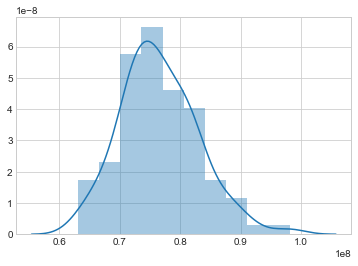

In [182]:
# resultpd['pred'].hist(bins=40)
sns.distplot(result)

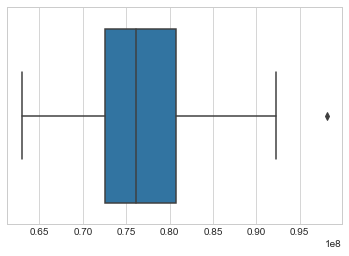

In [183]:
sns.boxplot(result)

In [184]:
# np.percentile(result, 25)
percs = np.percentile(result, [25,50,75])
print((percs[0]+percs[2])/2)
print (result.mean())
print(percs[1])

76650787.0375
76534668.7544
76153456.3


In [185]:
newdata = pd.read_excel('../datanew.xlsx')
newdata = newdata[newdata['Service Line Group']=='Technology']
print('Actual Sold')
newdata[(newdata['Close Period'] == targetPeriod)&(newdata['Sales Stage'].str.contains("Sold"))].sum()['Total Estimated Revenue']

Actual Sold


80224880

In [210]:
# Create Forecast


In [208]:
allResults = []

for period in futurePeriods:
    preddata = data[data['Close Period']==period].copy()
    alreadySold = preddata[preddata['Sales Stage']=="06 - Closed - Sold/Fermer - Vendu"].sum()['Total Estimated Revenue']
    preddata = preddata[~preddata['Sales Stage'].str.contains('Closed')]
    preddata = preddata.drop('Sales Stage', axis=1)
    preddata = preddata.drop("Close Period", axis=1)
    if (preddata.shape[0]>0):
        scaler = StandardScaler()
        scaler.fit(preddata)
        predscaled = scaler.transform(preddata)
        newpred = rf.predict(predscaled)
        newpred_prob = rf.predict_proba(predscaled )
        np.multiply([row[1] for row in newpred_prob] , preddata['Total Estimated Revenue']).sum()
        result =[]
        for i in range(1,200):
            result.append(runRf(x,y,predscaled))
        result = np.array(result)
        allResults.append(result.mean()+alreadySold)
    else:
        allResults.append(alreadySold)
    

allResults = pd.DataFrame(allResults, futurePeriods)

                      0
2018 - 01  5.824486e+07
2018 - 02  2.415322e+07
2018 - 03  4.526061e+07
2018 - 04  6.713640e+07
2018 - 05  7.587479e+07
2018 - 06  1.168352e+08
2018 - 07  5.240342e+07
2018 - 08  1.602674e+08
2018 - 09  9.842651e+07
2018 - 10  6.378423e+07
2018 - 11  3.218548e+07
2018 - 12  2.052386e+07
2018 - 13  1.829167e+07


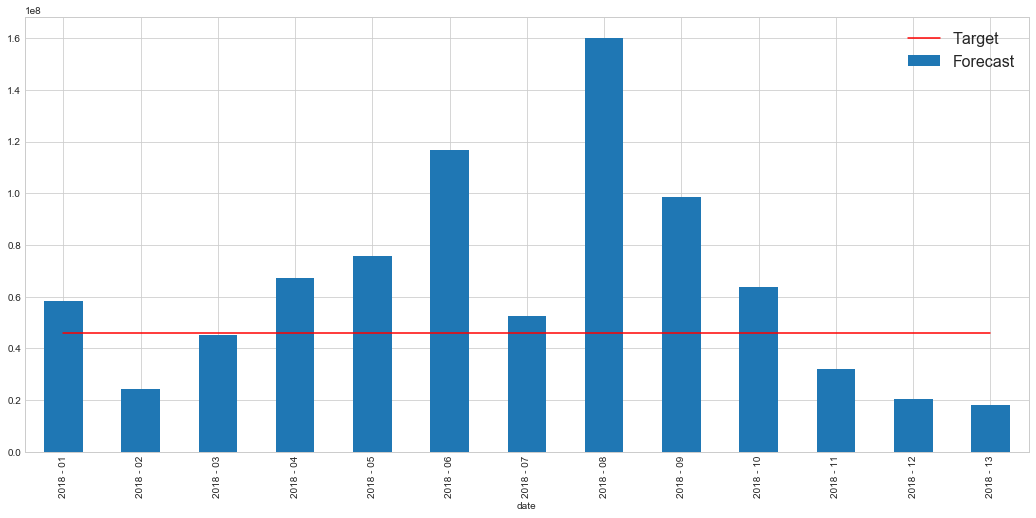

In [209]:
import matplotlib.pyplot as plt
target = pd.read_csv("../target.csv")

# target = target[target['date'].values >=targetPeriod]
target.set_index('date', inplace=True)
sns.set_style("whitegrid")
ax = target.plot(c='r', figsize=(18,8), label="Target")
print(allResults)

ax = allResults.plot.bar(ax=ax, label="line 1")
ax.legend(['Target', 'Forecast'], prop={'size': 16})
plt.savefig('foo.png')
